# Penalized Cox Models

[Cox's proportional hazard's model](https://en.wikipedia.org/wiki/Proportional_hazards_model) is often an appealing model, because its coefficients can be interpreted in terms of hazard ratio, which often provides valuable insight. However, if we want to estimate the coefficients of many features, the standard Cox model falls apart, because internally it tries to invert a matrix that becomes non-singular due to correlations among features.

## Ridge

This mathematical problem can be avoided by adding a $\ell_2$ penalty term on the coefficients that shrinks the coefficients to zero. The modified objective has the form
$$
\arg\max_{\beta}\quad\log \mathrm{PL}(\beta)
- \frac{\alpha}{2} \sum_{j=1}^p \beta_j^2 ,
$$

where $\mathrm{PL}(\beta)$ is the partial likelihood function of the Cox model, $\beta_1,\ldots,\beta_p$ are the coefficients for $p$ features, and $\alpha \geq 0$ is a hyper-parameter that controls the amount of shrinkage. The resulting objective is often referred to as *ridge regression*. If $\alpha$ is set to zero, we obtain the standard, unpenalized Cox model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

set_config(display="text")  # displays text representation of estimators

To demonstrate the use of penalized Cox models we are going to use the [breast cancer data](https://clincancerres.aacrjournals.org/content/13/11/3207), which contains the expression levels of 76 genes, age, estrogen receptor status (`er`), tumor size and grade for 198 individuals. The objective is to predict the time to distant metastasis.

First, we load the data and perform one-hot encoding of categorical variables `er` and `grade`.

In [2]:
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)
Xt.round(2).head()

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size
0,10.93,8.96,11.63,10.96,11.52,12.04,9.62,9.81,10.02,7.85,...,10.13,10.93,6.48,5.99,57.0,0.0,0.0,1.0,0.0,3.0
1,12.24,9.53,12.63,11.59,12.32,10.78,10.60,10.70,10.16,8.74,...,10.21,9.56,4.97,7.05,57.0,1.0,0.0,1.0,0.0,3.0
2,11.66,10.24,12.57,9.17,11.70,11.35,9.38,10.16,10.03,8.13,...,10.16,9.31,4.28,6.83,48.0,0.0,0.0,1.0,0.0,2.5
3,12.17,9.82,12.11,9.09,13.13,11.86,8.40,8.67,10.73,8.65,...,10.66,10.21,5.71,6.93,42.0,1.0,0.0,1.0,0.0,1.8
4,11.48,11.49,11.78,8.89,10.43,11.40,7.74,8.64,9.56,8.48,...,11.57,10.93,5.82,6.66,46.0,1.0,1.0,0.0,0.0,3.0


Let us begin by fitting a penalized Cox model to various values of $\alpha$ using [sksurv.linear_model.CoxPHSurvivalAnalysis](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html#sksurv.linear_model.CoxPHSurvivalAnalysis) and recording the coefficients we obtained for each $\alpha$.

In [3]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(Xt.columns)

Now, we can inspect how the coefficients change for varying $\alpha$.

In [4]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

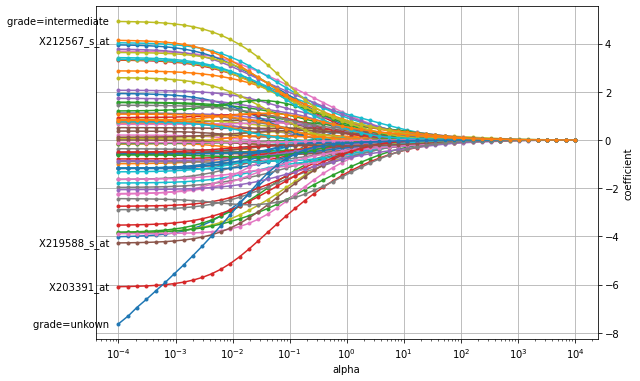

In [5]:
plot_coefficients(coefficients, n_highlight=5)

We can see that if the penalty has a large weight (to the right), all coefficients are shrunk almost to zero. As the penalty's weight is decreased, the coefficients' value increases. We can also observe that the paths for `X203391_at` and tumor grade quickly separate themselves from the remaining coefficients, which indicates that this particular gene expression level and tumor grade are important predictive factors for time to distant metastasis.

## LASSO

While the $\ell_2$ (ridge) penalty does solve the mathematical problem of fitting a Cox model, we would still need to measure the expression levels of all 76 genes to make predictions. Ideally, we would like to select a small subset of features that are most predictive and ignore the remaining gene expression levels. This is precisely what the LASSO (Least Absolute Shrinkage and Selection Operator) penalty does. Instead of shrinking coefficients to zero it does a type of continuous subset selection, where a subset of coefficients are set to zero and are effectively excluded. This reduces the number of features that we would need to record for prediction. In mathematical terms, the $\ell_2$ penalty is replaced by a $\ell_1$ penalty, which leads to the optimization problem

$$
\arg\max_{\beta}\quad\log \mathrm{PL}(\beta)
- \alpha \sum_{j=1}^p |\beta_j| .
$$

The main challenge is that we cannot directly control the number of features that get selected, but the value of $\alpha$ implicitly determines the number of features. Thus, we need a data-driven way to select a suitable $\alpha$ and obtain a parsimonious model. We can do this by first computing the $\alpha$ that would ignore all features (coefficients are all zero) and then incrementally decrease its value, let's say until we reach 1% of the original value. This has been implemented in [sksurv.linear_model.CoxnetSurvivalAnalysis](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.linear_model.CoxnetSurvivalAnalysis.html#sksurv.linear_model.CoxnetSurvivalAnalysis) by specifying `l1_ratio=1.0` to use the LASSO penalty and `alpha_min_ratio=0.01` to search for 100 $\alpha$ values up to 1% of the estimated maximum.

In [6]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

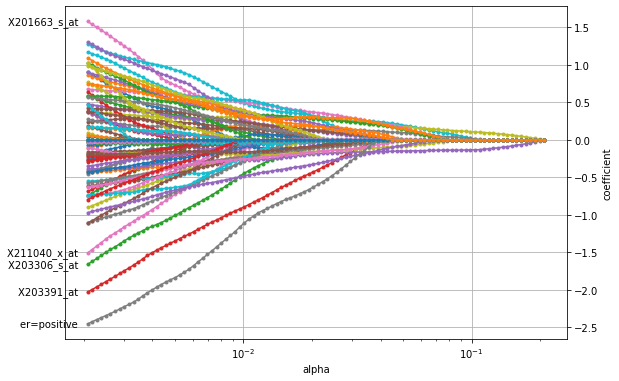

In [7]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=Xt.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

The figure shows that the LASSO penalty indeed selects a small subset of features for large $\alpha$ (to the right) with only two features (purple and yellow line) being non-zero. As $\alpha$ decreases, more and more features become active and are assigned a non-zero coefficient until the entire set of features is used (to the left left). Similar to the plot above for the ridge penalty, the path for `X203391_at` stands out, indicating its importance in breast cancer. However, the overall most important factor seems to be a positive estrogen receptor status (`er`).

## Elastic Net

The LASSO is a great tool to select a subset of discriminative features, but it has two main drawbacks. First, it cannot select more features than number of samples in the training data, which is problematic when dealing with very high-dimensional data. Second, if data contains a group of features that are highly correlated, the LASSO penalty is going to randomly choose one feature from this group. The Elastic Net penalty overcomes these problems by using a weighted combination of the $\ell_1$ and $\ell_2$ penalty by solving:

$$
\arg\max_{\beta}\quad\log \mathrm{PL}(\beta)
- \alpha
  \left( r \sum_{j=1}^p |\beta_j| + \frac{1 - r}{2} \sum_{j=1}^p \beta_j^2 \right) ,
$$

where $r \in [0; 1[$ is the relative weight of the $\ell_1$ and $\ell_2$ penalty. The Elastic Net penalty combines the subset selection property of the LASSO with the regularization strength of the Ridge penalty. This leads to better stability compared to the LASSO penalized model. For a group of highly correlated features, the latter would choose one feature randomly, whereas the Elastic Net penalized model would tend to select all. Usually, it is sufficient to give the $\ell_2$ penalty only a small weight to improve stability of the LASSO, e.g. by setting $r = 0.9$.

As for the LASSO, the weight $\alpha$ implicitly determines the size of the selected subset, and usually has to be estimated in a data-driven manner.

In [8]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

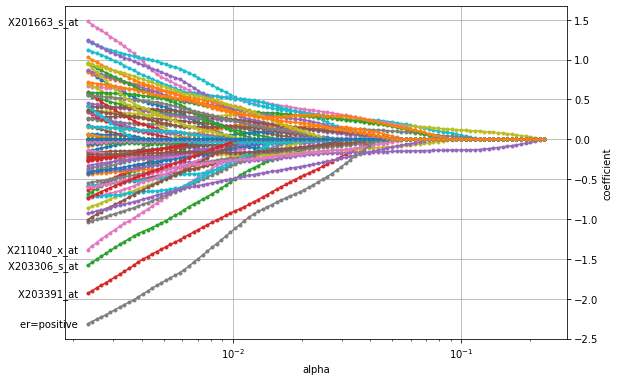

In [9]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

## Choosing penalty strength $\alpha$

Previously, we focused on the estimated coefficients to get some insight into which features are important for estimating time to distant metastasis. However, for prediction, we need to pick *one* particular $\alpha$, and the subset of features it implies. Here, we are going to use cross-validation to determine which subset and $\alpha$ generalizes best.

Before we can use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), we need to determine the set of $\alpha$ which we want to evaluate. To do this, we fit a penalized Cox model to the whole data and retrieve the estimated set of alphas. Since, we are only interested in alphas and not the coefficients, we can use only a few iterations for improved speed. Note that we are using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to account for scale differences among features and allow direct comparison of coefficients.

In [10]:
import warnings

from sklearn.exceptions import FitFailedWarning

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

Using the estimated set of alphas, we perform 5 fold cross-validation to estimate the performance – in terms of concordance index – for each $\alpha$.

*Note: this can take a while.*

In [11]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in map(float, estimated_alphas)]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

We can visualize the results by plotting the mean concordance index and its standard deviation across all folds for each $\alpha$.

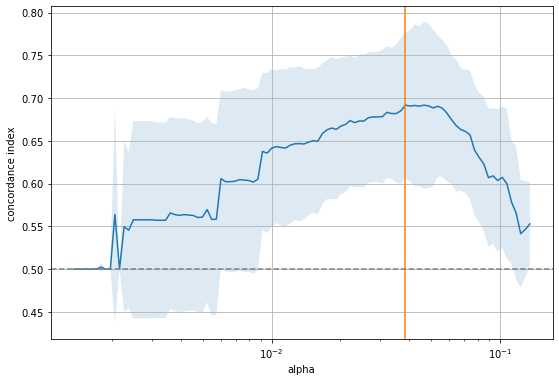

In [12]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

The figure shows that there is a range for $\alpha$ to the right where it is too large and sets all coefficients to zero, as indicated by the 0.5 concordance index of a purely random model. On the other extreme, if $\alpha$ becomes too small, too many features enter the model and the performance approaches that of a random model again. The sweet spot (orange line) is somewhere in the middle. Let's inspect that model.

Number of non-zero coefficients: 22


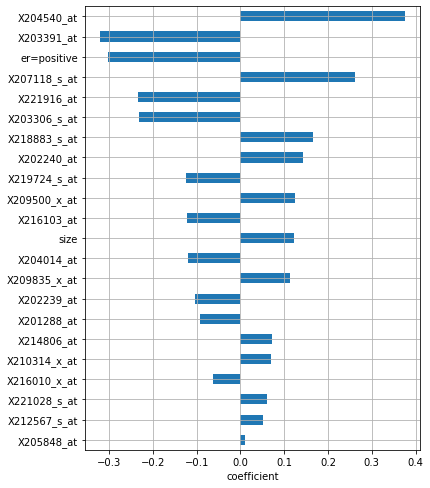

In [13]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

The model selected a total of 21 features, and it deemed `X204540_at` to be the most important one, followed by `X203391_at` and positive estrogen receptor status:


## Survival and Cumulative Hazard Function

Having selected a particular $\alpha$, we can perform prediction, either in terms of risk score using the [predict function](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.linear_model.CoxnetSurvivalAnalysis.html#sksurv.linear_model.CoxnetSurvivalAnalysis.predict) or in terms of survival or cumulative hazard function. For the latter two, we first need to re-fit the model with `fit_baseline_model` enabled.

In [14]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.03860196504106796],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

For instance, we can now select a patient and determine how positive or negative estrogen receptor status would affect the survival function.

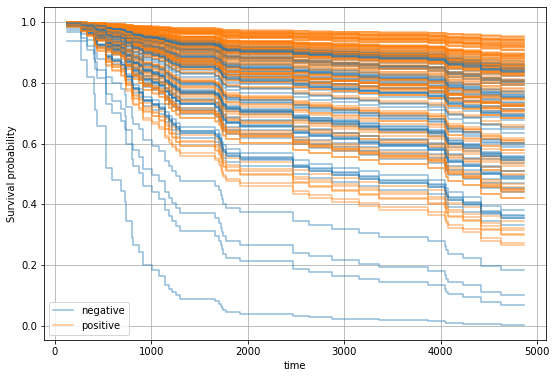

In [15]:
surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["t.tdm"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, Xt.loc[:, "er=positive"].astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

We can observe that patients with positive estrogen receptor status tend to have a better prognosis.